# Topog form stress using MOM025 DATA

Recent update 27 Sept 2017

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import pickle
from numpy import math

import pandas as pd
import xarray as xr
from glob import glob
from mpl_toolkits.basemap import Basemap, shiftgrid


# Load Data

In [12]:
g = 9.8

OceanFile1 = '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7/output100/ocean/ocean_grid.nc'
dsx1 = xr.open_dataset(OceanFile1, engine='netcdf4')

OceanFile2 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7/output100/ocean/ocean_month.nc'
dsx2 = xr.open_dataset(OceanFile2, engine='netcdf4')

OceanFile3 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7/output100/ocean/ocean.nc'
dsx3 = xr.open_dataset(OceanFile3, engine='netcdf4')


psum=np.zeros(1080)     # store sum pbot*dz in each latitude
pf=np.zeros([1080,1440])# store pbot*dz in each z-cell

for yy in range(100,400):
    kmt = dsx1.kmt.isel(yt_ocean=yy)    # "number of depth levels on t-grid"
    depth = dsx1.ht.isel(yt_ocean=yy)   # ht, depth
    pbot = dsx2.pbot_t.mean('time').isel(yt_ocean=yy)   # p_bot
    dz = dsx3.dzt.mean('time').isel(yt_ocean=yy)        # t-cell thickness
    rho = dsx3.rho.mean('time').isel(yt_ocean=yy)       # \rho in-situ    
    z=np.zeros(kmt.shape).astype(np.int64)              # define z initial
    z[:]=kmt[:].values-1                # layer number z[x]             
    dp = 0
    for x in range(0,1440):
        if (z[x]>-1)&(z[x-1]>-1):        
            if z[x]-z[x-1]==0:
                dz1=depth[x-1]-depth[x]
                if dz1<0:
                    rhom=rho[z[x],x]
                    pf[yy,x]=0+(10000*pbot[x]*(-dz1)-g*rhom*(dz1)**2/2)
                elif (dz1)>0:
                    rhom=rho[z[x-1],x-1]
                    pf[yy,x]=0-(10000*pbot[x-1]*(dz1)-g*rhom*(dz1)**2/2)
            else:
                if depth[x]-depth[x-1]>0:
                    dp=0
                    dz1=depth[x]-depth[x-1]   # total depth difference
                    pa=10000*pbot[x]          # choose pbot pressure
                    for i in range(0,z[x]-z[x-1]):  #calculate from bottom partial cell in each layer             
                        zm=dz[z[x]-i,x]             #correct length of dz of each partial cell
                        rhom=rho[z[x]-i,x]          #density
                        pm = pa-zm*g*rhom/2         #pressure at middle of each partial cell
                        dp=dp+pm*zm                 #press*dz in each partial cell
                        pa=pa-zm*g*rhom             #update press reference to upper partial cell
                    zm=dz[z[x-1],x]-dz[z[x-1],x-1] # The top cell
                    rhom=rho[z[x-1],x]                
                    pm = pa-zm*g*rhom/2
                    pf[yy,x]=dp+pm*zm               #record sum(p*dz) in one layer with + sign (east)
                elif depth[x]-depth[x-1]<0:
                    dp=0
                    dz1=depth[x-1]-depth[x]
                    pa=10000*pbot[x-1]
                    for i in range(0,z[x-1]-z[x]):
                        zm=dz[z[x-1]-i,x-1]
                        rhom=rho[z[x-1]-i,x-1]
                        pm = pa-zm*g*rhom/2
                        dp=dp+pm*zm
                        pa=pa-zm*g*rhom           
                    zm=dz[z[x],x-1]-dz[z[x],x]
                    rhom=rho[z[x],x-1]                
                    pm = pa-zm*g*rhom/2
                    pf[yy,x]=0-(dp+pm*zm)           #record sum(p*dz) in one layer with - sign (west)
        elif (z[x]>-1)&(z[x-1]<-1):
            dp=0
            pa=10000*pbot[x]
            for i in range(0,z[x]+1):
                zm=dz[z[x]-i,x]
                rhom=rho[z[x]-i,x]
                pm = pa-zm*g*rhom/2
                dp=dp+pm*zm
                pa=pa-zm*g*rhom
            pf[yy,x]=0+dp                  
        elif (z[x]<-1)&(z[x-1]>-1):
            dp=0
            pa=10000*pbot[x-1]
            for i in range(0,z[x-1]+1):
                zm=dz[z[x-1]-i,x-1]
                rhom=rho[z[x-1]-i,x-1]
                pm = pa-zm*g*rhom/2
                dp=dp+pm*zm
                pa=pa-zm*g*rhom
            pf[yy,x]=0-dp                                   
    psum[yy]=np.sum(pf[yy,:])                   #record sum(p*dz) in one latitude


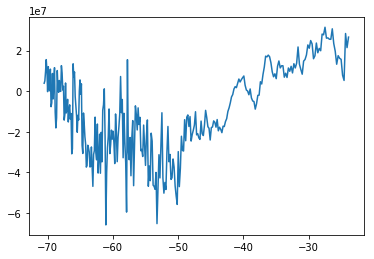

In [13]:
lat = dsx1.yt_ocean[100:400]
plt.plot(lat,psum[100:400])

## Summary:

## Without correction for dz (partial cell depth), $\sum \Delta pbot \Delta z\sim 10^7$. 